# Bibliothèques

In [3]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

%matplotlib inline

# Fonctions

In [3]:
##############################################
# Fonctions liées à l'extraction des données
##############################################

def filtrer(src, dst, date):
    date=[date]
    for line in src:
        if 'mentions.CSV' not in line:
            continue
        arr = line.split(' ')
        for time in date:
            if time in arr[2]:
                dst.write(arr[0]+' '+arr[1]+' '+arr[2])
                
def dezip(filezip, pathdst = ''): 
    if pathdst == '': pathdst = os.getcwd()  ## on dezippe dans le repertoire locale 
    zfile = zipfile.ZipFile(filezip, 'r') 
    for i in zfile.namelist():  ## On parcourt l'ensemble des fichiers de l'archive 
        #print (i) 
        if os.path.isdir(i):   ## S'il s'agit d'un repertoire, on se contente de creer le dossier 
            try: os.makedirs(pathdst + os.sep + i) 
            except: pass 
        else: 
            try: os.makedirs(pathdst + os.sep + os.path.dirname(i)) 
            except: pass 
            data = zfile.read(i)                   ## lecture du fichier compresse 
            fp = open(pathdst + os.sep + i, "wb")  ## creation en local du nouveau fichier 
            fp.write(data)                         ## ajout des donnees du fichier compresse dans le fichier local 
            fp.close() 
    zfile.close() 

    
def open_data(fichier):
    #data=pd.read_csv(fichier,sep="\t",header=None)
    #column_names=['GlobalEventID','EventTimeDate','MentionTimeDate','MentionType','MentionSourceName','MentionIdentifier','SentenceID','Actor1CharOffset','Actor2CharOffset','ActionCharOffset','InRawText','Confidence','MentionDocLen','MentionDocTone','MentionDocTranslationInfo','Extras']
    #data.columns=column_names
    data = pd.read_csv(fichier,sep = '\t',decimal = '.',index_col=0)
    return data

In [4]:
def creation_fichier_csv(date):

    # Création du fichier contenant uniquement les liens des fichier mentions qui nous interressent
    source = open("masterfilelist.txt", "r") # Ouverture du fichier source
    destination = open("data_list.csv", "w") # Ouverture du fichier destination
    filtrer(source, destination, date) # Filtrage
    destination.close()# Fermeture du fichier destination
    source.close()# Fermerture du fichier source

    #enregistrement fichier csv
    master_data = pd.read_csv('data_list.csv',sep= ' ',header = None,engine='python')
    master_data.columns = ['1','2','url']

    #suppression lignes inutiles
    for index, row in master_data.iterrows():
        if '.mentions.CSV' not in row['url']:
            master_data = master_data.drop(index)

    # vide le dossier où stocker les donnees
    for element in os.listdir("C:/Users/maell/Fake_News_Project/data_folder"):
        path="C:/Users/maell/Fake_News_Project/data_folder/"+element
        os.remove(path)

    #telecharge et dezippe les fichiers depuis le web
    for index, row in master_data.iterrows():
        element = row['url']
        urllib.request.urlretrieve(element,'file')
        dezip('file', 'data_folder')

    # Création du DataFrame Complet
    column_names=['GlobalEventID','EventTimeDate','MentionTimeDate','MentionType','MentionSourceName','MentionIdentifier','SentenceID','Actor1CharOffset','Actor2CharOffset','ActionCharOffset','InRawText','Confidence','MentionDocLen','MentionDocTone','MentionDocTranslationInfo','Extras']
    all_data=pd.DataFrame({'GlobalEventID':[],'EventTimeDate':[],'MentionTimeDate':[],'MentionType':[],'MentionSourceName':[],'MentionIdentifier':[],'SentenceID':[],'Actor1CharOffset':[],'Actor2CharOffset':[],'ActionCharOffset':[],'InRawText':[],'Confidence':[],'MentionDocLen':[],'MentionDocTone':[],'MentionDocTranslationInfo':[],'Extras':[]},columns = column_names, index=[])

    for fichier in os.listdir("C:/Users/maell/Fake_News_Project/data_folder"):
        path_fichier="C:/Users/maell/Fake_News_Project/data_folder/"+fichier
        new_data=open_data(path_fichier)
        all_data = pd.concat([all_data,new_data],ignore_index = True)

    # Sauvegarde du fichier all_data.csv
    nom_fichier='all_data_'+date+'.csv'
    all_data.to_csv(nom_fichier, sep='\t', decimal= '.')
    print(nom_fichier+' enregistré')


In [5]:
#####################
# Création de graphs
#####################

#Création d'un graph binaire 
def graph_sources(data,G):
    fichier='all_data_'+date+'.csv'
    data=open_data(fichier)
    
    for source in data.MentionSourceName.unique():
        # add is nan
        G.add_node(source)
    for event in data.GlobalEventID.unique():
        list_source=data[data.GlobalEventID==event].MentionSourceName
        for source1 in list_source:
            for source2 in list_source:
                if source1!=source2:
                    G.add_edge(source1,source2)

#Création d'un graph avec comme poids le nombre d'évenements partagés
def graph_sources_poids(data,G):
    fichier='all_data_'+date+'.csv'
    print(fichier)
    data=open_data(fichier)
    
    for source in data.MentionSourceName.unique():
        G.add_node(source)
    for event in data.GlobalEventID.unique():
        liste_source=data[data.GlobalEventID==event].MentionSourceName
        for comb in combinations(liste_source,2):
            if comb[0]!=comb[1]:
                if G.has_edge(comb[0],comb[1]):
                    G[comb[0]][comb[1]]['weight'] += 1
                else:
                    G.add_edge(comb[0], comb[1], weight=1)
                    
def cleaning_graph(G):
    edges_to_remove = []
    for edge in G.edges():
        if G[edge[0]][edge[1]]['weight']<5:
            edges_to_remove.append(edge)
    if(edges_to_remove!=[]):
        G.remove_edges_from(edges_to_remove)

    # Suppression des éléments non connectés
    composants=list(nx.connected_components(G))
    i=0;
    while i<len(composants):
        if len(composants[i])==1:
            composant_supp=list(composants[i])[0]
            G.remove_node(composant_supp)
        i=i+1
        
    # Suppression des nan
    if source in G.nodes():
        if isnan(source):
            G.remove_node(source)
        
def classification_géographique_url(graph):
    for source in graph.nodes():
        if source.endswith(".au"):
            graph.node[source]['URL']='Australia'
            graph.node[source]['Country']='Australia'
        elif source.endswith(".uk"):
            graph.node[source]['URL']='UK'
            graph.node[source]['Country']='UK'
        elif source.endswith(".in"):
            graph.node[source]['URL']='India'
            graph.node[source]['Country']='India'
        elif source.endswith(".nz"):
            graph.node[source]['URL']='New Zealand'
            graph.node[source]['Country']='New Zealand'
        elif source.endswith(".org"):
            graph.node[source]['URL']='Organization'
            graph.node[source]['Country']='Organization'
        elif source.endswith(".us"):
            graph.node[source]['URL']='USA'
            graph.node[source]['Country']='USA'
        elif source.endswith(".international"):
            graph.node[source]['URL']='International'
            graph.node[source]['Country']='International'
        elif source.endswith(".zm"):
            graph.node[source]['URL']='Zambia'
            graph.node[source]['Country']='Zambia'
        elif source.endswith(".ca"):
            graph.node[source]['URL']='Canada'
            graph.node[source]['Country']='Canada'
        elif source.endswith(".za"):
            graph.node[source]['URL']='South Africa'
            graph.node[source]['Country']='South Africa'
        else:
            graph.node[source]['URL']='Not Classified'
            

def dataframe_url(graph):
    dataframe=pd.DataFrame({'WebsiteURL':[], 'URL':[]},columns = ['WebsiteURL','URL'],index=[])
    for source in graph.nodes():
        if source.endswith(".au"):
            url='Australia'
        elif source.endswith(".uk"):
             url='UK'
        elif source.endswith(".in"):
             url='India'
        elif source.endswith(".nz"):
             url='New Zealand'
        elif source.endswith(".org"):
             url='Organization'
        elif source.endswith(".us"):
             url='USA'
        elif source.endswith(".international"):
             url='International'
        elif source.endswith(".zm"):
             url='Zambia'
        elif source.endswith(".ca"):
             url='Canada'
        elif source.endswith(".za"):
             url='South Africa'
        else:
            url='Not Classified'
        dataframe = dataframe.append([{'WebsiteURL':source,'URL':url}], ignore_index=True)
    return dataframe

def classification_géographique_csv(graph):
    countries = pd.read_csv('source_country.csv',sep = ';',decimal = '.')
    for source in graph.nodes():
        if source in countries.WebsiteURL.values :
            liste_pays=countries[countries.WebsiteURL==source]
            pays=liste_pays['Country'].value_counts().index[0]
            graph.node[source]['pays']=pays
            
def create_country_reference(G):
    #Récupération des dataframes de référence
    countries = pd.read_csv('source_country.csv',sep = ';',decimal = '.')
    url = dataframe_url(G)
    
    #Création d'un dataframe de référence unique
    countries=countries[['WebsiteURL','Country']]
    countries.set_index('WebsiteURL',inplace=True)
    url.set_index('WebsiteURL',inplace=True)

    reference= url.join(countries)
    reference= reference[~reference.index.duplicated(keep='first')] #On supprime les lignes multiples
    reference= reference.fillna(value='Not Classified') #On remplace NaN par 'Not Classified'

    #Mise à zéro du nombre de différences
    diff_url_csv=0

    # Mise en forme du dataframe de reference
    for index,row in reference.iterrows():
        ligne=reference.loc[index]
        if ligne.Country=='Not Classified':
            ligne.Country=ligne.URL
        if ligne.Country!='Not Classified'  and ligne.URL!=ligne.Country:
            diff_url_csv+=1
        
    #supprier la colone url
    reference.drop('URL',1)

    #Print
    print('Nombre de sites ayant un pays issus de l\'URL différent de celui issu du CSV :',diff_url_csv)
    
    return reference

# Check for the False, Misleading, Clickbait and/or Satirical “News” Sources

## Obtaining the list of controversial website

### For one date

In [2]:
fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

**Remarque :** Les labels "political" et "relable" ne sont pas des sites contreversés mais des sites de "confiance".

In [ ]:
day='20180530'#'20180930'
file='graph_'+day+'.gexf'
G=nx.read_gexf(file)

In [ ]:
nodes=list(G.nodes);

our_fake_sites=[]
for node in nodes:
    for site in fake_news_sources:
        if node==site:
            our_fake_sites.append(site)
            G.node[node]['Controversial Website']=fake_news_sources_df.loc[site].type
            
print('List of controversial website in our graph :')
print('(Source : https://docs.google.com/document/u/1/d/10eA5-mCZLSS4MQY5QGb5ewC3VAL6pLkT53V_81ZyitM/mobilebasic )')
for i in range (0,len(our_fake_sites)):
    print(our_fake_sites[i],' (',fake_news_sources_df.loc[our_fake_sites[i]].type,')')

In [ ]:
file_name='graph_'+day+'FakeNews.gexf'
nx.write_gexf(G,file_name)

### For several dates

In [7]:
fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

def controversial_website_in_graph(fake_news_sources, date, register=False): #REVOIR ICI ARGUMENT OPTIONNEL !!!
    file='graph_'+date+'.gexf'
    G=nx.read_gexf(file)

    for node in list(G.nodes):
        if node in fake_news_sources:
                G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:       
            G.node[node]['Controversial Website']=None

    if register==True:
        file_name='graph_'+day+'_controversial_website.gexf'
        nx.write_gexf(G,file_name)
        
    return(G)

def label_controversial_website(G): #OK
    fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
    fake_news_sources_df.set_index('url',inplace=True)
    fake_news_sources=list(fake_news_sources_df.index.unique())
    for node in list(G.nodes):
        if node in fake_news_sources:
                G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:       
            G.node[node]['Controversial Website']=None
    return (G)

## Checking controversial website in graph

In [91]:
list_days= ['20170830','20170930','20171030','20171130','20171230','20180130','20180227','20180330','20180412','20180430','20180530','20180630','20180730','20180830','20180930']

column_names=['date', 'total website','reliable','political','total controversial','bias','fake','conspiracy','unreliable','satire','hate','clickBait','junksci','rumor','unreliable','state']
df_controversial_website=pd.DataFrame(columns=column_names);

for day in list_days:
    H=controversial_website_in_graph(fake_news_sources,day)
    H_type=dict(H.node('Controversial Website')).values()
    c=Counter(H_type)
    # If counter not working, check 'Classification_Website_False.csv' : some website may be twice in the list
    total_controversial=len(H.nodes)-c[None]-c['political']-c['reliable']
    df_controversial_website=df_controversial_website.append({'date': day, 'total website':len(H.nodes), 'political':c['political'], 'reliable':c['reliable'],'total controversial':total_controversial,'bias':c['bias'],'fake':c['fake'],'conspiracy':c['conspiracy'],'unreliable':c['unreliable'],'satire':c['satire'],'hate':c['hate'],'clickBait':c['clickBait'],'junksci':c['junksci'],'rumor':c['rumor'],'unreliable':c['unreliable'],'state':c['state']}, ignore_index=True)
    print(day+' OK')

df_controversial_website = df_controversial_website.set_index('date')
df_controversial_website

20170830 OK


NetworkXError: Input is not a correct NetworkX graph.

In [92]:
print('Average number of controversial website by graph :',mean(df_controversial_website['total controversial']))
print('Average % of controversial website in the graph :', mean(df_controversial_website['total controversial']/df_controversial_website['total website']))
print('-----------------------------FAKE NEWS SITE-----------------------------')
print('Average number of bias website by graph :',mean(df_controversial_website['bias']))
print('Average number of conspiracy website by graph :',mean(df_controversial_website['conspiracy']))
print('-----------------------------CONFIDENCE WEB SITE--------------------------------')
print('Average number of political website by graph :',mean(df_controversial_website['political']))
print('Average number of reliable website by graph :',mean(df_controversial_website['reliable']))

Average number of controversial website by graph : 51.0
Average % of controversial website in the graph : 0.007947639083683964
-----------------------------FAKE NEWS SITE-----------------------------
Average number of bias website by graph : 23.0
Average number of conspiracy website by graph : 7.0
-----------------------------CONFIDENCE WEB SITE--------------------------------
Average number of political website by graph : 25.0
Average number of reliable website by graph : 2.0


**Commentaire :** Nous disposons en moyenne d'un bon nombre de sites contreversés, représentant une faible proportion de nos graphs. Ils sont principalement composé de sites biaisé et de conspiration. La base de données propose aussi une reconnaissance des sites de confiance : nous en avons environ le même nombre.

**Piste à poursuivre :** Comparer les sites fiables et non fiables : à qui sont-ils liés ? Comment sont-ils liés entre eux ?

# Sub-Graph of Controversial Website

In [2]:
# Read website classification referency
fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

In [3]:
# Select controversial and confidence website
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unreliable','satire','hate','clickBait','junksci','rumor','unreliable','state','controversial']

confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

## Total sub graph (controversial + confidence website)

In [66]:
# Select day
date='20171230'

# Load graph file
file='graph_'+date+'.gexf'
G=nx.read_gexf(file)

# Add labels with controversial website
G=controversial_website_in_graph(fake_news_sources, date)

In [67]:
# Creating sub graph
list_sub_graph=[]
for node in list(G.nodes):
    for site in fake_news_sources:
        if node==site:
            list_sub_graph.append(node)
G_total_sub_graph=G.subgraph(list_sub_graph)

# Saving sub graph
file_name='graph_'+date+'_total_sub_graph.gexf'
nx.write_gexf(G_total_sub_graph,file_name)

In [ ]:
print('Average degree :',mean(list(dict(G_total_sub_graph.degree()).values())))
print('Average weighted degree :',mean(list(dict(G_total_sub_graph.degree(weight='weight')).values())))

## Controversial Sub Graph

In [ ]:
# Creating sub graph
list_sub_graph=[]
for node in list(G.nodes):
    for site in controversial_website:
        if node==site:
            list_sub_graph.append(node)
G_controversial_sub_graph=G.subgraph(list_sub_graph)

# Saving sub graph
file_name='graph_'+date+'_controversial_sub_graph.gexf'
nx.write_gexf(G_controversial_sub_graph,file_name)

In [ ]:
print('Average degree :',mean(list(dict(G_controversial_sub_graph.degree()).values())))
print('Average weighted degree :',mean(list(dict(G_controversial_sub_graph.degree(weight='weight')).values())))

**Remarque** : Connecté à peu de voisins, mais très fortement

# Confidence Sub Graph

In [ ]:
# Creating sub graph
list_sub_graph=[]
for node in list(G.nodes):
    for site in confidence_website:
        if node==site:
            list_sub_graph.append(node)
G_confidence_sub_graph=G.subgraph(list_sub_graph)

# Saving sub graph
file_name=ph.gexf'
nx.write_gexf(G_confidence_sub_graph,file_name)

In [ ]:
print('Average degree :',mean(list(dict(G_confidence_sub_graph.degree()).values())))
print('Average weighted degree :',mean(list(dict(G_confidence_sub_graph.degree(weight='weight')).values())))

**Remarque :** Connecté à plus de voisins, mais moins fortement

# Classification of Website (Controversal or Confidence)

## Seulement les noeuds connus

Based on : G_total_subgraph

In [28]:
def label_propagation_controversial_website(critere, fake_news_sources_df,date,confidence_type,controversial_type,show_results=None,show_working=None):

# Openning G_total_sub_graph
    try:
        file_path='graph_'+date+'_total_sub_graph.gexf'
        G_total_sub_graph=nx.read_gexf(file_path)
    except:
        print('graph_',date,'_total_sub_graph.gexf does not exist.')
        return
        
# Create train and test set
    total_set=list(G_total_sub_graph.nodes())
    test_set=[]
    train_set=[]

    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            G_total_sub_graph.node[total_set[i]]['Controversial Website']=None #delete referency
        else:
            train_set.append(total_set[i])
            
# Classification
    compteur=0;
    compteur_retry=0;

    test_set_qui_se_vide=test_set.copy()

    while test_set_qui_se_vide!=[]:
        #On tire un point au hasard
        number_nodes=len(test_set_qui_se_vide)
        if number_nodes>1:
            node=test_set_qui_se_vide[random.randint(0,number_nodes-1)]
        else:
            node=test_set_qui_se_vide[0]
        
        #On regarde ses voisins
        list_neighboor=list(G_total_sub_graph.neighbors(node))
        controversial_weight=0;
        confidence_weight=0;
        for neighboor in list_neighboor:
            if G_total_sub_graph.nodes[neighboor]['Controversial Website'] is None:
                test=0
            elif G_total_sub_graph.nodes[neighboor]['Controversial Website'] in confidence_type:
                confidence_weight+=G_total_sub_graph.edges[node,neighboor]['weight']
            elif G_total_sub_graph.nodes[neighboor]['Controversial Website'] in controversial_type:
                controversial_weight+=G_total_sub_graph.edges[node,neighboor]['weight']
            
        if confidence_weight==controversial_weight :
            compteur_retry+=1
            if show_working==True:
                print('Retry',compteur_retry)
            if compteur_retry>40:
                if show_working==True:
                    print('END')
                break
        else:
            #critere=0.50
            if confidence_weight>critere*controversial_weight:
                G_total_sub_graph.node[node]['Controversial Website']='confidence'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
            elif controversial_weight>critere*confidence_weight:
                G_total_sub_graph.node[node]['Controversial Website']='controversial'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
                
    # Evaluation

    confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
    controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

    
    well_classified_confidence=0;
    well_classified_controversial=0;
    bad_classified=0;
    for node in test_set:
        if G_total_sub_graph.nodes[node]['Controversial Website'] in confidence_type and node in confidence_website:
            well_classified_confidence+=1
        elif G_total_sub_graph.nodes[node]['Controversial Website'] in controversial_type and node in controversial_website :
            well_classified_controversial+=1
        elif G_total_sub_graph.nodes[node]['label'] in test_set_qui_se_vide :
            test=0
        else:
            bad_classified+=1

    if show_results==True:
        print('Number of nodes to classified :',len(test_set))
        print('Number of nodes not classified :',number_nodes,'-',100*number_nodes/len(test_set),'%')
        print('Number of well classified nodes :',well_classified,'-',100*(well_classified_confidence+well_classified_controversial)/len(test_set),'%')
        print('Number of bad classifed nodes :',bad_classified,'-',100*bad_classified/len(test_set),'%')
    
    return(G_total_sub_graph, len(test_set),number_nodes,well_classified_controversial,well_classified_confidence,bad_classified)
# total_sub_graph, nb nodes to classifie, nb nodes not classified, well_classified nodes, bad classified nodes

### Choix du critère

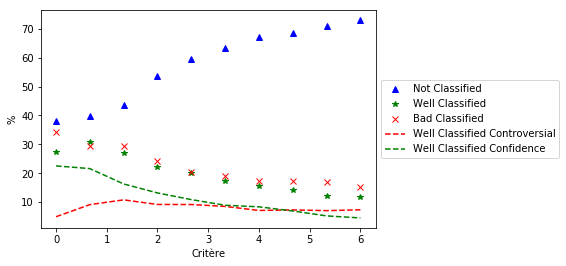

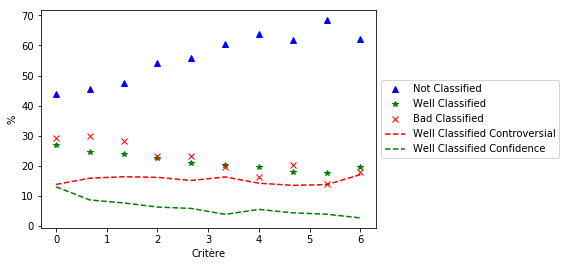

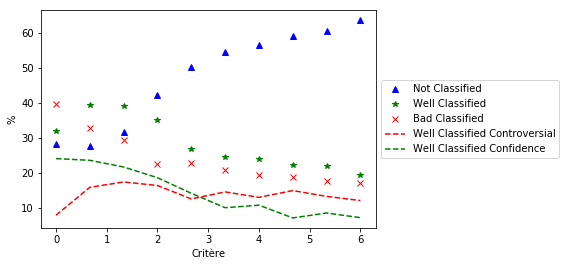

In [32]:
date_liste=['20170830','20171230','20180830']

confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unreliable','satire','hate','clickBait','junksci','rumor','unreliable','state','controversial']
f=50 #folds for validation
for date in date_liste:
    list_not_classified=[];
    list_well_classified=[];
    list_well_classified_controversial=[]
    list_well_classified_confidence=[]
    list_bad_classified=[];

    list_critere= np.linspace(0, 6, num=10)

    for critere in list_critere:
        mean_not_classified=0
        mean_well_classified=0
        mean_bad_classified=0
        mean_well_classified_controversial=0;
        mean_well_classified_confidence=0;

        for i in range (0,f):
            [G_total_sub_graph, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website(critere,fake_news_sources_df, date,confidence_type,controversial_type)
            mean_not_classified+=not_classified/to_classify
            mean_well_classified_controversial+=well_classified_controversial/to_classify
            mean_well_classified_confidence+=well_classified_confidence/to_classify
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            mean_bad_classified+=bad_classified/to_classify

        list_not_classified.append(100*mean_not_classified/f)
        list_well_classified.append(100*mean_well_classified/f)
        list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
        list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
        list_bad_classified.append(100*mean_bad_classified/f)

    # plot graph
    plt.figure(date)
    
    plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
    plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
    plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
    plt.xlabel('Critère')
    plt.ylabel('%')

    plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
    plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Remarque :** Dans tous les cas, c'est moyennement satisfaisant : toujours plus d'erreur que de juste ... Et beaucoup de non classifiés ... Un random serait meilleur ... -> On va tenter d'intégrer les voisins

## Les noeuds connus + leurs voisins

In [24]:
fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unreliable','satire','hate','clickBait','junksci','rumor','unreliable',
                    'state','controversial','unknown']

params=[confidence_type, controversial_type, fake_news_sources_df]

In [10]:
def label_propagation_controversial_website_neighbor(G,list_known_nodes,list_neighbors,critere,params,
                                                     show_results=None,show_working=None):

    #Récupération des paramètres 
    [confidence_type, controversial_type, fake_news_sources_df]=params
    
    #Create train and test set
    total_set=list_known_nodes
    test_set=[]
    train_set=[]
    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            G.node[total_set[i]]['Controversial Website']=None #delete referency
        else:
            train_set.append(total_set[i])
            
    # Classification
    compteur=0;
    compteur_retry=0;

    test_set_qui_se_vide=test_set.copy()
    test_set_qui_se_vide += list_neighbors
    
    while test_set_qui_se_vide!=[]:
        #On tire un point au hasard
        number_nodes=len(test_set_qui_se_vide)
        if number_nodes>1:
            node=test_set_qui_se_vide[random.randint(0,number_nodes-1)]
        else:
            node=test_set_qui_se_vide[0]
        
        #On regarde ses voisins
        list_node_neighbor=list(G.neighbors(node))
        
        controversial_weight=0;
        confidence_weight=0;
        for neighboor in list_node_neighbor:
            value=G.node[neighboor]['Controversial Website']
            if value in confidence_type:
                confidence_weight+=G.edges[node,neighboor]['weight']
            elif value in controversial_type:
                controversial_weight+=G.edges[node,neighboor]['weight']
            
        if confidence_weight==controversial_weight :
            compteur_retry+=1
            if show_working==True:
                print('Retry',compteur_retry)
            if compteur_retry>30: #100 avant
                if show_working==True:
                    print('END')
                break
        else:
            if confidence_weight>critere*controversial_weight:
                G.node[node]['Controversial Website']='confidence'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
            elif controversial_weight>critere*confidence_weight:
                G.node[node]['Controversial Website']='controversial'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
                
    # Evaluation

    confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
    controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

    
    well_classified_confidence=0;
    well_classified_controversial=0;
    bad_classified=0;
    for node in test_set:
        if G.nodes[node]['Controversial Website'] in confidence_type and node in confidence_website:
            well_classified_confidence+=1
        elif G.nodes[node]['Controversial Website'] in controversial_type and node in controversial_website :
            well_classified_controversial+=1
        elif G.nodes[node]['label'] in test_set_qui_se_vide :
            test=0
        else:
            bad_classified+=1

    well_classified=well_classified_confidence+well_classified_controversial
    not_classified=len(test_set)-well_classified-bad_classified
    if show_results==True:
        print('Number of nodes to classified :',len(test_set))
        print('Number of nodes not classified :',not_classified,'-',100*(not_classified)/len(test_set),'%')
        print('Number of well classified nodes :',well_classified,'-',100*well_classified/len(test_set),'%')
        print('Number of bad classifed nodes :',bad_classified,'-',100*bad_classified/len(test_set),'%')
        
    # DF resultat
    df_resultat=pd.DataFrame(columns=['Reference','Found','WebsiteURL'])
    df_resultat.set_index('WebsiteURL',inplace=True)
    for node in test_set:
        df_resultat=df_resultat.append({'WebsiteURL':node, 'Reference':fake_news_sources_df.loc[node].type, 'Found':G.nodes[node]['Controversial Website']}, ignore_index=True)
        
    
    return(G, df_resultat, len(test_set),not_classified,well_classified_controversial,well_classified_confidence,bad_classified)
# total_sub_graph, nb nodes to classifie, nb nodes not classified, well_classified nodes, bad classified nodes

In [6]:
def create_neighbor_sub_graph(fake_news_sources,date):
# Create the sub-graph of controversial website + neighbor

    G=controversial_website_in_graph(fake_news_sources, date)
    list_sub_graph=[]
    list_known_nodes=[]
    list_neighbors=[]
    for node in list(G.nodes):
        for site in fake_news_sources:
            if node==site:
                list_sub_graph.append(node) #pour le sous-graph
                list_known_nodes.append(node) #ceux qu'on connait
                neighbors=list(G.neighbors(node)) # les voisins
                list_sub_graph += neighbors#pour le sous-graph
                list_neighbors += neighbors #liste des voisins (ceux qu'on connait pas)
                
    list_sub_graph=list(set(list_sub_graph)) #to get unique ones
    list_neighbors=list(set(list_neighbors))
    list_neighbors=[val for val in list_neighbors if val not in list_known_nodes] #soit on est connu soit on est voisin
    
    G_neighbor_sub_graph=G.subgraph(list_sub_graph)
    
    return(G_neighbor_sub_graph,list_known_nodes,list_neighbors)

In [12]:
date_liste=['20180830','20171230','20180830']

confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unreliable','satire','hate','clickBait','junksci','rumor','unreliable','state','controversial']
f=5#10 #folds for validation
for date in date_liste:
    list_not_classified=[];
    list_well_classified=[];
    list_well_classified_controversial=[]
    list_well_classified_confidence=[]
    list_bad_classified=[];

    list_critere= np.linspace(0, 20, num=5)
    
    [G,list_known_nodes,list_neighbors]=create_neighbor_sub_graph(fake_news_sources,date)

    for critere in list_critere:
        mean_not_classified=0
        mean_well_classified=0
        mean_bad_classified=0
        mean_well_classified_controversial=0;
        mean_well_classified_confidence=0;

        for i in range (0,f):
            print('f=',i,'et critere=',critere)
            [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_neighbor(G,list_known_nodes,list_neighbors,critere,params,show_results=None,show_working=None)
            
            mean_not_classified+=not_classified/to_classify
            mean_well_classified_controversial+=well_classified_controversial/to_classify
            mean_well_classified_confidence+=well_classified_confidence/to_classify
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            mean_bad_classified+=bad_classified/to_classify


        list_not_classified.append(100*mean_not_classified/f)
        list_well_classified.append(100*mean_well_classified/f)
        list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
        list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
        list_bad_classified.append(100*mean_bad_classified/f)

    # plot graph
    plt.figure()
    
    plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
    plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
    plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
    plt.xlabel('Critère')
    plt.ylabel('%')

    plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
    plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(date)

f= 0 et critere= 0.0
f= 1 et critere= 0.0
f= 2 et critere= 0.0
f= 3 et critere= 0.0
f= 4 et critere= 0.0
f= 0 et critere= 5.0


KeyboardInterrupt: 

In [85]:
# Etude pour la meilleur solution (critère=15)

date='20180830'
f=15;
critere=15;
[G_neighbor_sub_graph,list_known_nodes,list_neighbors]=create_neighbor_sub_graph(fake_news_sources,date)
df_res_total=pd.DataFrame();
for i in range (0,f):
    [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_neighbor(G_neighbor_sub_graph,list_known_nodes,list_neighbors,critere,params,show_results=None,show_working=None)
    
    df_res=df_res.set_index('WebsiteURL')
    df_res.drop('Reference',1, inplace=True);
    df_res.rename(columns={'Found':i}, inplace=True)

    #Merge with df_res_total
    df_res_total=pd.merge(df_res_total, df_res,how='outer',left_index=True, right_index=True) #, right_index=True, left_index=True
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [118]:
#Count the most appearance type
list_c_type=[]
list_c_number=[]
list_confidence=[]
for index,row in df_res_total.iterrows():
    ligne=df_res_total.loc[index]
    columns=df_res_total.columns
    liste=[]
    for i in range (len(df_res_total.columns)):
        liste.append(ligne[i])
    c = Counter(liste)
    nb_nan=c[nan]
    if pd.isnull(c.most_common(1)[0][0]):                
        if c.most_common(1)[0][1]==len(df_res_total.columns):
            list_c_type.append('Not Classified')
            list_c_number.append(0)
            list_confidence.append(0)
        else:
            list_c_type.append(c.most_common(2)[1][0])
            list_c_number.append(c.most_common(2)[1][1])
            list_confidence.append(c.most_common(2)[1][1]/(len(df_res_total.columns)-nb_nan))
    else:
        list_c_type.append(c.most_common(1)[0][0])
        list_c_number.append(c.most_common(1)[0][1])
        list_confidence.append(c.most_common(1)[0][1]/(len(df_res_total.columns)-nb_nan))
        
df_res_total['Most appearance found type'] =list_c_type
df_res_total['Nb of appearance'] =list_c_number
df_res_total['Confidence'] =list_confidence

#Add reference column
fake_news_sources_df.index.names = ['WebsiteURL']
reference=fake_news_sources_df.type.to_frame()
df_res_total=pd.merge(df_res_total, reference, how='inner',left_index=True, right_index=True) 

df_res_total['type'].replace(confidence_type, 'confidence', inplace=True)
df_res_total['type'].replace(controversial_type, 'controversial', inplace=True)

#Print results
print('Number of well classified :',len(df_res_total[df_res_total['Most appearance found type']==df_res_total['type']]))
print('Number of bad classified :',len(df_res_total[df_res_total['Most appearance found type']!=df_res_total['type']]))

Number of well classified : 25
Number of bad classified : 38


In [130]:
print('Number of confidence referencies:',len(df_res_total[df_res_total['type']=='confidence']))
print('Number of controversial referencies:',len(df_res_total[df_res_total['type']=='controversial']))
print('Number total of referencies :',len(df_res_total['type']))

Number of confidence referencies: 26
Number of controversial referencies: 37
Number total of referencies : 63


In [119]:
df_res_total

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Most appearance found type,Nb of appearance,Confidence,type
WebsiteURL,,,,,,,,,,,,,,,,,,,
advocate.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confidence,NaN,NaN,NaN,confidence,1,1.000000,confidence
alternet.org,confidence,confidence,NaN,confidence,NaN,confidence,confidence,confidence,confidence,confidence,confidence,confidence,NaN,confidence,NaN,confidence,11,1.000000,confidence
americanthinker.com,confidence,confidence,NaN,confidence,NaN,NaN,confidence,confidence,confidence,NaN,confidence,NaN,NaN,NaN,NaN,confidence,7,1.000000,controversial
antiwar.com,NaN,confidence,NaN,NaN,NaN,NaN,confidence,NaN,confidence,NaN,NaN,NaN,NaN,NaN,NaN,confidence,3,1.000000,controversial
blacklistednews.com,NaN,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,5,1.000000,controversial
breitbart.com,NaN,NaN,NaN,confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confidence,NaN,confidence,confidence,3,1.000000,confidence
canadafreepress.com,NaN,NaN,confidence,confidence,confidence,NaN,NaN,NaN,confidence,NaN,NaN,NaN,NaN,NaN,NaN,confidence,4,1.000000,controversial
christianpost.com,confidence,confidence,confidence,NaN,confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confidence,4,1.000000,confidence
commentarymagazine.com,confidence,NaN,NaN,confidence,NaN,confidence,NaN,NaN,confidence,NaN,NaN,NaN,NaN,NaN,confidence,confidence,5,1.000000,confidence


In [134]:
print('Mean of confidence :',mean(df_res_total['Confidence'].values))
print('Mean nb of appearance :',mean(df_res_total['Nb of appearance'].values))

Mean of confidence : 0.9758818342151675
Mean nb of appearance : 4.761904761904762


In [132]:
# df_confusion = pd.crosstab(df_res_total['type'], df_res_total['Most appearance found type'])
# plot_confusion_matrix(df_confusion)

In [125]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)
s = df_confusion.style.background_gradient(cmap=cm)#"YlOrBr")
s

Most appearance found type,confidence
type,
confidence,25
controversial,33


In [22]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=90)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

#### Remarque sur les critères
0 favorise les "confidant" -> car dès que 1 confidant, c'est confidant

\>1 favorise les "controversial" -> ils ont plus de poids

## Tout le graph

In [14]:
def label_propagation_controversial_website_total(G,critere,params,show_results=None,show_working=None):

    #Récupération des paramètres 
    [confidence_type, controversial_type, fake_news_sources_df]=params
    
    #Create labels of nodes
    G=label_controversial_website(G);
    
    #Create list know nodes and other nodes
    list_known_nodes=[]
    list_other_nodes=[]
    for node in list(G.nodes):
        if node in fake_news_sources:
            list_known_nodes.append(node)
        else:
            list_other_nodes.append(node)
    list_known_nodes=list(set(list_known_nodes))
    list_other_nodes=list(set(list_other_nodes))
    
    #Create train and test set
    total_set=list_known_nodes
    test_set=[]
    train_set=[]
    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            G.node[total_set[i]]['Controversial Website']=None #delete referency
        else:
            train_set.append(total_set[i])
            
    # Classification
    compteur=0;
    compteur_retry=0;

    test_set_qui_se_vide=test_set.copy()
    test_set_qui_se_vide += list_other_nodes
    
    while test_set_qui_se_vide!=[]:
        #On tire un point au hasard
        number_nodes=len(test_set_qui_se_vide)
        if number_nodes>1:
            node=test_set_qui_se_vide[random.randint(0,number_nodes-1)]
        else:
            node=test_set_qui_se_vide[0]
        
        #On regarde ses voisins
        list_node_neighbor=list(G.neighbors(node))
        
        controversial_weight=0;
        confidence_weight=0;
        for neighboor in list_node_neighbor:
            value=G.node[neighboor]['Controversial Website']
            if value in confidence_type:
                confidence_weight+=G.edges[node,neighboor]['weight']
            elif value in controversial_type:
                controversial_weight+=G.edges[node,neighboor]['weight']
            
        if confidence_weight==controversial_weight :
            compteur_retry+=1
            if show_working==True:
                print('Retry',compteur_retry)
            if compteur_retry>100:
                if show_working==True:
                    print('END')
                break
        else:
            if confidence_weight>critere*controversial_weight:
                G.node[node]['Controversial Website']='confidence'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
            elif controversial_weight>critere*confidence_weight:
                G.node[node]['Controversial Website']='controversial'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
                
    # Evaluation

    confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
    controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

    
    well_classified_confidence=0;
    well_classified_controversial=0;
    bad_classified=0;
    for node in test_set:
        if G.nodes[node]['Controversial Website'] in confidence_type and node in confidence_website:
            well_classified_confidence+=1
        elif G.nodes[node]['Controversial Website'] in controversial_type and node in controversial_website :
            well_classified_controversial+=1
        elif G.nodes[node]['label'] in test_set_qui_se_vide :
            test=0
        else:
            bad_classified+=1

    well_classified=well_classified_confidence+well_classified_controversial
    not_classified=len(test_set)-well_classified-bad_classified
    if show_results==True:
        print('Number of nodes to classified :',len(test_set))
        print('Number of nodes not classified :',not_classified,'-',100*(not_classified)/len(test_set),'%')
        print('Number of well classified nodes :',well_classified,'-',100*well_classified/len(test_set),'%')
        print('Number of bad classifed nodes :',bad_classified,'-',100*bad_classified/len(test_set),'%')
        
    # DF resultat
    df_resultat=pd.DataFrame(columns=['Reference','Found','WebsiteURL'])
    df_resultat.set_index('WebsiteURL',inplace=True)
    for node in test_set:
        df_resultat=df_resultat.append({'WebsiteURL':node, 'Reference':fake_news_sources_df.loc[node].type, 'Found':G.nodes[node]['Controversial Website']}, ignore_index=True)
        
    
    return(G, df_resultat, len(test_set),not_classified,well_classified_controversial,well_classified_confidence,bad_classified)
# total_sub_graph, nb nodes to classifie, nb nodes not classified, well_classified nodes, bad classified nodes

In [6]:
#Parameters
date='20180830'
critere=15

#Open graph
file='graph_'+date+'.gexf'
G=nx.read_gexf(file)

#Run type propagation

#[G_neighbor_sub_graph, df_resultat, len(test_set),not_classified,well_classified_controversial,well_classified_confidence,bad_classified]=label_propagation_controversial_website_total(G,critere,params)

f= 0 et critere= 0.0
f= 1 et critere= 0.0
f= 2 et critere= 0.0
f= 3 et critere= 0.0
f= 4 et critere= 0.0
f= 0 et critere= 5.0
f= 1 et critere= 5.0
f= 2 et critere= 5.0
f= 3 et critere= 5.0
f= 4 et critere= 5.0
f= 0 et critere= 10.0
f= 1 et critere= 10.0
f= 2 et critere= 10.0
f= 3 et critere= 10.0
f= 4 et critere= 10.0
f= 0 et critere= 15.0
f= 1 et critere= 15.0
f= 2 et critere= 15.0
f= 3 et critere= 15.0
f= 4 et critere= 15.0
f= 0 et critere= 20.0
f= 1 et critere= 20.0
f= 2 et critere= 20.0
f= 3 et critere= 20.0
f= 4 et critere= 20.0
f= 0 et critere= 0.0
f= 1 et critere= 0.0
f= 2 et critere= 0.0
f= 3 et critere= 0.0
f= 4 et critere= 0.0
f= 0 et critere= 5.0
f= 1 et critere= 5.0
f= 2 et critere= 5.0
f= 3 et critere= 5.0
f= 4 et critere= 5.0
f= 0 et critere= 10.0
f= 1 et critere= 10.0
f= 2 et critere= 10.0
f= 3 et critere= 10.0
f= 4 et critere= 10.0
f= 0 et critere= 15.0
f= 1 et critere= 15.0
f= 2 et critere= 15.0
f= 3 et critere= 15.0
f= 4 et critere= 15.0
f= 0 et critere= 20.0
f= 1 et 

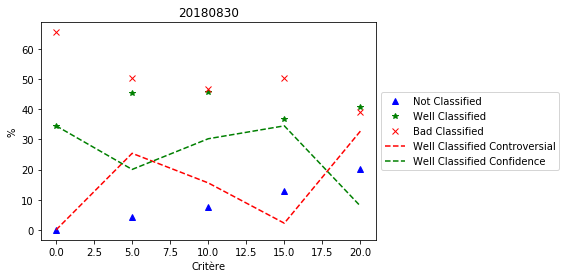

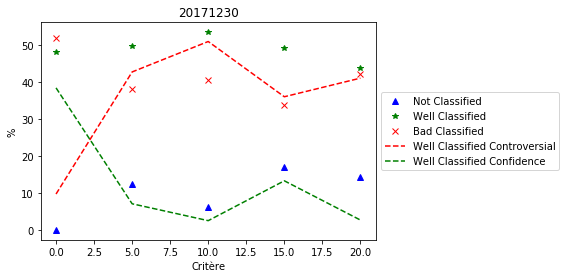

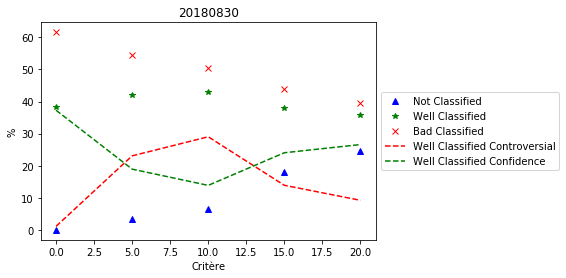

In [14]:
date_liste=['20180830','20171230','20180830']

confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unreliable','unknown','satire','hate','clickBait','clickbait','junksci','rumor','unreliable','state','controversial']
f=5 #folds for validation
for date in date_liste:
    list_not_classified=[];
    list_well_classified=[];
    list_well_classified_controversial=[]
    list_well_classified_confidence=[]
    list_bad_classified=[];

    list_critere= np.linspace(0, 20, num=5)
    
    file='graph_'+date+'.gexf'
    G=nx.read_gexf(file)

    for critere in list_critere:
        mean_not_classified=0
        mean_well_classified=0
        mean_bad_classified=0
        mean_well_classified_controversial=0;
        mean_well_classified_confidence=0;

        for i in range (0,f):
            #print('f=',i,'et critere=',critere)
            [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params)
            
            mean_not_classified+=not_classified/to_classify
            mean_well_classified_controversial+=well_classified_controversial/to_classify
            mean_well_classified_confidence+=well_classified_confidence/to_classify
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            mean_bad_classified+=bad_classified/to_classify


        list_not_classified.append(100*mean_not_classified/f)
        list_well_classified.append(100*mean_well_classified/f)
        list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
        list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
        list_bad_classified.append(100*mean_bad_classified/f)

    # plot graph
    plt.figure()
    
    plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
    plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
    plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
    plt.xlabel('Critère')
    plt.ylabel('%')

    plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
    plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(date)

## Etude de la meilleur solution (critère=10)
maybe not the best solution ... NEED TO LOOK AT THIS !!

In [124]:
# Etude pour la meilleur solution (critère=15)

date='20180830'
f=30;
critere=10;

confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','unreliable','satire','hate','clickBait','clickbait','junksci','rumor','unreliable','state','controversial']

file='graph_'+date+'.gexf'
G=nx.read_gexf(file)
    
df_res_total=pd.DataFrame();
for i in range (0,f):
    [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params)
    
    df_res=df_res.set_index('WebsiteURL')
    df_res.drop('Reference',1, inplace=True);
    df_res.rename(columns={'Found':i}, inplace=True)

    #Merge with df_res_total
    df_res_total=pd.merge(df_res_total, df_res,how='outer',left_index=True, right_index=True) #, right_index=True, left_index=True
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [125]:
#Count the most appearance type
list_c_type=[]
list_c_number=[]
list_confidence=[]
for index,row in df_res_total.iterrows():
    ligne=df_res_total.loc[index]
    columns=df_res_total.columns
    liste=[]
    for i in range (len(df_res_total.columns)):
        liste.append(ligne[i])
    c = Counter(liste)
    nb_nan=c[nan]
    if pd.isnull(c.most_common(1)[0][0]):                
        if c.most_common(1)[0][1]==len(df_res_total.columns):
            list_c_type.append('Not Classified')
            list_c_number.append(0)
            list_confidence.append(0)
        else:
            list_c_type.append(c.most_common(2)[1][0])
            list_c_number.append(c.most_common(2)[1][1])
            list_confidence.append(c.most_common(2)[1][1]/(len(df_res_total.columns)-nb_nan))
    else:
        list_c_type.append(c.most_common(1)[0][0])
        list_c_number.append(c.most_common(1)[0][1])
        list_confidence.append(c.most_common(1)[0][1]/(len(df_res_total.columns)-nb_nan))
        
df_res_total['Most appearance found type'] =list_c_type
df_res_total['Nb of appearance'] =list_c_number
df_res_total['Confidence'] =list_confidence

#Add reference column
fake_news_sources_df.index.names = ['WebsiteURL']
reference=fake_news_sources_df.type.to_frame()
df_res_total=pd.merge(df_res_total, reference, how='inner',left_index=True, right_index=True) 

df_res_total['type'].replace(confidence_type, 'confidence', inplace=True)
df_res_total['type'].replace(controversial_type, 'controversial', inplace=True)

In [126]:
#Print results
print('Number of well classified :',len(df_res_total[df_res_total['Most appearance found type']==df_res_total['type']]))
print('Number of not classified :',len(df_res_total[df_res_total['Most appearance found type'].isnull()]))
print('Number of bad classified:',len(df_res_total[df_res_total['Most appearance found type']!=df_res_total['type']])-len(df_res_total[df_res_total['Most appearance found type'].isnull()]))

Number of well classified : 33
Number of not classified : 1
Number of bad classified: 29


In [127]:
df_res_total['Most appearance found type'].replace([None], 'Not Classified', inplace=True)

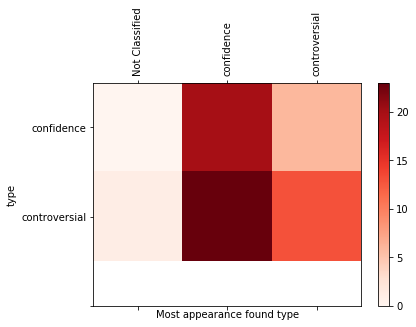

In [128]:
df_confusion = pd.crosstab(df_res_total['type'], df_res_total['Most appearance found type'])
plot_confusion_matrix(df_confusion)

In [129]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)
s = df_confusion.style.background_gradient(cmap=cm)#"YlOrBr")
s

Most appearance found type,Not Classified,confidence,controversial
type,,,
confidence,0,20,6
controversial,1,23,13
